#  Distinguish Positive and Negative Documents

In [0]:
data_dir = 'data'
!ls {data_dir}

sample_submission.csv  test.csv  train.csv  words_list.npy  word_vectors.npy


In [0]:
import os
import sys
import time
import datetime
import math

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import tensorflow as tf

# Enable Eager Execution
tf.enable_eager_execution()
tf.executing_eagerly() 

import warnings
warnings.filterwarnings("ignore")

## Dataset analysis

In [0]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
train_df.head()

,id,text,class
0,14feb4e5,"Đến quán 2 lần thôi , rất là thích !\nQuán tuy...",1
1,9c6f6036,Đến quán vào tối chủ_nhật . Có band hát . Khá ...,0
2,0f462cfe,Phục_vụ lâu quá mặc_dù khách rất vắng .\nĐợi g...,0
3,741fd21b,"Ko gian bé_tí , quán chật_chội , đông người nê...",0
4,5cd6dbbc,"Khi mình order , đặt bánh thì nhận được sự tiế...",1


Negative: 13482
Positive: 13518
Proportion: 1.0 : 1


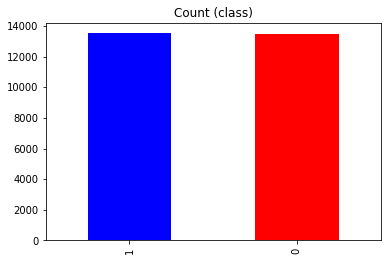

In [0]:
class_count = train_df['class'].value_counts()
print('Negative:', class_count[0])
print('Positive:', class_count[1])
print('Proportion:', round(class_count[0] / class_count[1], 2), ': 1')

class_count.plot(kind='bar', title='Count (class)', color=['blue', 'red']);

In [0]:
print('A positive sentence: ')
sample_positive = train_df[train_df['class'] == 1].sample(1)
print(sample_positive.loc[sample_positive.index[0], 'text'])

print('\nA negative sentence: ')
sample_negative = train_df[train_df['class'] == 0].sample(1)
print(sample_negative.loc[sample_negative.index[0], 'text'])


A positive sentence: 
Phải nói là không đếm được bao_nhiêu lần đã ăn_ở quán này rồi nhưng vẫn kết nổ đĩa . Nhược_điểm là chuyển địa_điểm quá nhiều . Mình đã ăn_ở chỗ LƯ ơng Đình_Của sau đó chuyển sang Phương_Mai , đc một thời_gian lại sang Chùa_Bộc và hôm nọ mới sang chỗ mới nhất_là số 1 Đào_Duy_Anh . Đi tìm quán đến chóng_mặt nhưng vì ăn quen rồi ko sang chỗ khác đc . ăn_ở chỗ khác cứ thấy vị nó không ngon bằng ở đây
Về không_gian : Quán hiện_nay 2 tầng . Ngồi trên gác thì chắc là_hơi bí ( mình chưa thử ) . Dưới sân thì rộng , kê được nhiều bàn . Chăng đèn_điện các thứ khá là đẹp_mắt nhg mà lúc khói lên thì cái gì cũng mờ_mờ nhé .
Về chất_lượng : Vẫn giữ phong_độ ổn_định , thêm mấy món mới như mực_ống với diềm thăn cả một loại bò thái vuông vuông mà quên xừ tên rồi .
Về giá_cả : Ở đây khách đa_số sinh_viên nên giá cũng rất là sinh_viên tầm 100K một người là no . Hôm nào uống rượu thì 120K
Về phục_vụ : Cái này hơi kém mà quán cần sửa_chữa , nhân_viên toàn nhỏ nhỏ_con con nên làm hơi ch

In [0]:
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
test_df.head()

,id,text
0,3afca6c4,"Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà..."
1,a52dd7db,Ăn ở đây từ trc khi chủ nhà xây nhà mới . ch...
2,a95ec3a0,Các bạn đến ăn ngay và luôn đi nhé ! !\nMình t...
3,68c1c84a,Đây gần như quán ruột của mình luôn : ) ) đây ...
4,627bbd02,Tiếc là 25 năm sống ở Tây Ninh thì đây là lần ...


### Load vocabulary and matrix word embedding
Fasttext pretrain model: https://s3-us-west-1.amazonaws.com/fasttext-vectors/word-vectors-v2/cc.vi.300.vec.gz

In [0]:
words_list = np.load(os.path.join(data_dir, 'words_list.npy'))
print('Simplified vocabulary loaded!')
words_list = words_list.tolist()
word_vectors = np.load(os.path.join(data_dir, 'word_vectors.npy'))
word_vectors = np.float32(word_vectors)
print ('Word embedding matrix loaded!')

Simplified vocabulary loaded!
Word embedding matrix loaded!


In [0]:
print('Size of the vocabulary: ', len(words_list))
print('Size of the word embedding matrix: ', word_vectors.shape)

Size of the vocabulary:  19899
Size of the word embedding matrix:  (19899, 300)


### Get word vector of single word

In [0]:
ngon_idx = words_list.index('ngon')
print('Index of `ngon` in words_list: ', ngon_idx)
ngon_vec = word_vectors[ngon_idx]
print('Vector representation of `ngon` is: ', ngon_vec)

Index of `ngon` in words_list:  14598
Vector representation of `ngon` is:  [-2.040e-02 -9.800e-03  2.290e-01 -3.770e-02  5.430e-02 -2.680e-02
  2.190e-02 -6.290e-02 -2.200e-02 -1.010e-02  8.300e-03 -8.810e-02
 -3.630e-02  7.820e-02 -7.780e-02 -4.930e-02 -6.600e-03 -1.026e-01
 -1.040e-02  5.380e-02  4.100e-02  6.530e-02 -2.770e-02 -6.340e-02
  2.270e-02  4.420e-02  3.340e-02 -4.960e-02  8.290e-02 -3.990e-02
  3.750e-02  1.800e-02 -1.115e-01 -7.200e-02 -5.060e-02 -1.051e-01
 -4.560e-02 -1.765e-01 -3.300e-02 -6.800e-03  5.580e-02 -4.180e-02
  4.380e-02  4.940e-02  7.400e-03  4.020e-02 -8.850e-02 -9.840e-02
 -5.210e-02 -5.500e-03  3.730e-02 -8.460e-02 -6.910e-02 -4.980e-02
 -3.910e-02 -4.980e-02 -8.690e-02  6.100e-03 -5.360e-02 -3.800e-03
  1.162e-01 -4.160e-02  5.000e-03 -7.240e-02 -3.320e-02  1.800e-02
  1.200e-02 -4.420e-02  1.350e-01  6.580e-02 -1.110e-02  1.960e-02
  1.750e-02  2.010e-02  2.200e-03  1.810e-01 -6.610e-02 -6.860e-02
 -4.690e-02  7.890e-02  6.880e-02 -5.320e-02  2.770e-0

In [0]:
# UNK as unknow word
zero_vec = words_list[-1]
print('Vector representation of `unknow` is: ', zero_vec)

Vector representation of `unknow` is:  UNK


### Preprocessing documents

In [0]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^\w0-9 ]+")

def clean_sentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

### Transfer comments to word embedding matrix

In [0]:
def get_sentence_indices(sentence, max_seq_length, _words_list):
    
    indices = np.zeros((max_seq_length), dtype='int32')
    
    # Split sentance to words
    words = [word.lower() for word in sentence.split()]
    
    words = words[:max_seq_length]
    for idx, word in enumerate(words):
      if(word in _words_list):
        indices[idx] = _words_list.index(word)
      else:
        indices[idx] = len(_words_list)-1
    return indices

In [0]:
# Example: Ma trận biểu diễn cho một câu

sentence = "Món này ăn hoài không biết chán"

sentence = clean_sentences(sentence)
# Get word index
sentence_indices = get_sentence_indices(sentence, max_seq_length=10, _words_list=words_list)

print(sentence_indices.shape)
print('Row index for each word: ', sentence_indices)

print('Sentence representation of word vectors:')
print(tf.nn.embedding_lookup(word_vectors,sentence_indices).shape)

(10,)
Row index for each word:  [  119  8136  4884 18791 16614 15951  3371     0     0     0]
Sentence representation of word vectors:
Instructions for updating:
Colocations handled automatically by placer.
(10, 300)


### Analysis Train dataset

In [0]:
num_words = [len(clean_sentences(x).split()) for x in list(train_df['text'])]
print('The total number of samples is', len(train_df))
print('The total number of words in the files is', sum(num_words))
print('The average number of words in the files is', sum(num_words)/len(num_words))

The total number of samples is 27000
The total number of words in the files is 2252760
The average number of words in the files is 83.43555555555555


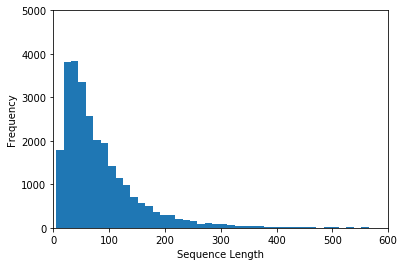

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(num_words, 100)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 600, 0, 5000])
plt.show()

Follow histogram we select MAX_SEQ_LENGTH is 200

In [0]:
MAX_SEQ_LENGTH = 200

### Change words to matrix

In [0]:
def text2ids(df, max_length, _word_list):
    """
    Change text to id in matrix
    
    Parameters
    ----------
    df: DataFrame
    max_length: int
    _word_list: numpy.array
    
    Returns
    -------
    numpy.array
        len(df) x max_length contains indices of text
    """
    ids = np.zeros((len(df), max_length), dtype='int32')
    for idx, text in enumerate(tqdm(df['text'])):
        ids[idx,:] = get_sentence_indices(clean_sentences(text), max_length, _word_list)
    return ids

In [0]:
print("Converting train_df...")
train_ids = text2ids(train_df, MAX_SEQ_LENGTH, words_list)
np.save('train_ids.npy', train_ids)


  0%|          | 7/27000 [00:00<06:59, 64.36it/s]

Converting train_df...


100%|██████████| 27000/27000 [08:37<00:00, 52.16it/s]


In [0]:
# Trường hợp đã tính toán và lưu ma trận rồi thì ta có thể load lên
train_ids = np.load('train_ids.npy')

In [0]:
print('Word indexes of the first review: ', train_ids[0])

Word indexes of the first review:  [10774 11975  4826  7446  6880 10642  5767 18584 11975  7090  5284  8591
 15213 18109 10642 11022  4690 11975 16032 10630  2465 14595  2750  8231
  2563 10627  7733  9133  3513 19798  2876 10627  1047 12844 13512  7555
 14312 13245  3961   376 19772 15253 16614 17330 17016 10642 14598 15341
  3913 19519  9334 15522 13952 13245  5596 15221 12109 14341 14017   556
 17115 19151 18839 10346  9076 18584 11975  3364     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    

In [0]:
vocab_size = train_ids.max() + 1

### Split into train, validation và test

**train : validation : test = 0.8 : 0.1 : 0.1**

In [0]:
train_x, test_validation_x, train_y, test_validation_y  = train_test_split(train_ids, train_df['class'], test_size=0.2, random_state=2019)
validation_x, test_x, validation_y, test_y = train_test_split(test_validation_x, test_validation_y, test_size=0.5, random_state=2018)

In [0]:
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(batch_size=BATCH_SIZE)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_x,validation_y)).batch(batch_size=BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x,test_y)).batch(batch_size=BATCH_SIZE)

In [0]:
for idx, (x,y) in enumerate(train_dataset):
    if idx == 0:
        print(x)
print("Total: ", idx)

tf.Tensor(
[[12844  5596  4884 ...     0     0     0]
 [10774 16521 13952 ...     0     0     0]
 [ 7446 10698 10774 ...     0     0     0]
 ...
 [ 4884 16995  4601 ...     0     0     0]
 [ 3913 15085 14017 ...     0     0     0]
 [ 4788 14598   310 ...     0     0     0]], shape=(256, 200), dtype=int32)
Total:  84


In [0]:
vocab_size

19899

## Build RNN model

### Create LSTM layer

In [0]:
if tf.test.is_gpu_available():
    lstm_layer = tf.keras.layers.CuDNNLSTM
else:
    import functools
    lstm_layer = functools.partial(
            tf.keras.layers.LSTM, recurrent_activation='sigmoid')

In [0]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        
        #hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(values))) #+ self.W2(hidden_with_time_axis)))
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [0]:
LSTM_UNITS = 128
N_LAYERS = 2
NUM_CLASSES = 2

In [0]:
class SentimentAnalysisModel(tf.keras.Model):
    def __init__(self, word2vec, lstm_units, n_layers, num_classes, dropout_rate=0.4):
        super().__init__(name='sentiment_analysis')
        self.word2vec = word2vec
        
        self.lstm_layers = [] # LSTM layer
        self.dropout_layers = [] # dropout layer
        
        for i in range(n_layers):
            self.lstm_layers.append(lstm_layer(lstm_units, return_sequences=True))
            self.dropout_layers.append(tf.keras.layers.Dropout(dropout_rate))
            
        self.dense_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.attention = BahdanauAttention(lstm_units)
        ### END CODE HERE
        
    def call(self, inputs):
        out = inputs
        out = tf.nn.embedding_lookup(self.word2vec, out)
        for i in range(len(self.lstm_layers)):
            out = self.lstm_layers[i](out)
            out = self.dropout_layers[i](out)
        out = self.attention(out)
        out = self.dense2(out)
        out = self.dropout(out)
        out = self.dense_layer(out)
        return out
        

### Build CNN model

In [0]:
class CNNModel(tf.keras.Model):
    def __init__(self, word2vec, num_classes, dropout_rate=0.2):
        super().__init__(name='CNNModel')
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, 300, 
                           weights=[word2vec], 
                           input_length=MAX_SEQ_LENGTH, 
                           trainable=True)
        
        self.conv1D = tf.keras.layers.Conv1D(256, 3, activation='relu')
        self.conv1D2 = tf.keras.layers.Conv1D(64, 3, activation='relu')
        self.pool = tf.keras.layers.GlobalMaxPool1D()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.softmax = tf.keras.layers.Dense(num_classes, activation='softmax')
        
        self.flattern = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.sdropout = tf.keras.layers.SpatialDropout1D(0.2)
        
    def call(self, inputs):
        out = inputs
        out = self.embedding(out)
        out = self.sdropout(out)
        out = self.conv1D(out)
        out = self.pool(out)
        out = self.dense1(out)
        out = self.dropout(out)
        out = self.softmax(out)
        return out
        

Khởi tạo mô hình

In [0]:
#model = SentimentAnalysisModel(word_vectors, LSTM_UNITS, N_LAYERS, NUM_CLASSES)
model = CNNModel(word_vectors, NUM_CLASSES)

In [0]:
model2 = SentimentAnalysisModel(word_vectors, LSTM_UNITS, N_LAYERS, NUM_CLASSES)

### Train model

Train parameters

In [0]:
LEARNING_RATE = 0.001
EPOCHS = 64

In [0]:
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

In [0]:
global_step = tf.train.get_or_create_global_step()

checkpoint_dir = './model'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{score}")

In [0]:
from fastprogress import master_bar, progress_bar

In [0]:
def epoch_training(model, dataset, global_step, mb, num_step):
    """
    Returns
    -------
    float
        mean loss of a epoch
    """
    train_losses = [] 
    val_gt = []
    val_pred = [] 
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, target = next(dataset_iter)
        val_gt.extend(target.numpy().astype(np.int32).tolist())
        with tf.GradientTape() as tape:
            # Feedforward
            predictions = model(inp)
            loss = tf.losses.sparse_softmax_cross_entropy(target, predictions) # sparse_softmax_cross_entropy
            train_losses.append(loss) # Add loss into list train_losses
        
        # gradient between loss and model
        grads = tape.gradient(loss, model.trainable_variables)
        # Optimize weights depend on gradient
        optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step=global_step)

        val_pred.extend(tf.argmax(predictions,1).numpy().astype(np.int32).tolist())
        mb.child.comment = 'Train loss {:.4f}'.format(loss)
    return sum(train_losses)/ len(train_losses), f1_score(val_gt, val_pred)

In [0]:
def epoch_evaluation(model, dataset, mb, num_step):
    
    val_losses = [] 
    val_gt = [] 
    val_pred = []
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, target = next(dataset_iter)
        
        val_gt.extend(target.numpy().astype(np.int32).tolist())
        
        # Feed forward
        predictions = model(inp)
        
        loss = tf.losses.sparse_softmax_cross_entropy(target, predictions)
        
        val_losses.append(loss)
        
        val_pred.extend(tf.argmax(predictions,1).numpy().astype(np.int32).tolist())
        
        mb.child.comment = 'Validation loss {:.4f}'.format(loss)
        
    return (sum(val_losses)/ len(val_losses)), f1_score(val_gt, val_pred), precision_score(val_gt, val_pred)

In [0]:
best_score = 0
mb = master_bar(range(EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'F1']
training_losses = []
validation_losses = []
f1_scores = []
x = []

train_step = math.ceil(len(train_x)*1.0/BATCH_SIZE)
val_step = math.ceil(len(validation_x)*1.0/BATCH_SIZE)
for epoch in mb:
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    x.append(epoch)
    
    # Training
    training_loss, train_score = epoch_training(model, train_dataset, global_step, mb, train_step)
    
    mb.write('Finish train epoch {} with loss {:.4f}'.format(epoch, training_loss))
    training_losses.append(training_loss)
    
    # Validating
    valid_loss, valid_score, pre_score = epoch_evaluation(model, validation_dataset, mb, val_step)
    mb.write('Finish validate epoch {} with loss {:.4f} f1_score {:.4f} precision {:.4f}'.format(epoch,valid_loss, valid_score, pre_score))
    validation_losses.append(valid_loss)
    f1_scores.append(valid_score)
    
    global_step.assign_add(1)
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, f1_scores]], [0,EPOCHS], [0,1])
    
    if best_score < valid_score:
        mb.write("Improved f1-score from {:.4f} to {:.4f}".format(best_score, valid_score))
        
        best_score = valid_score

        model.save_weights('model_cnn.h5')

### Valid on testset

In [0]:
#model.load_weights(checkpoint_prefix)
model.load_weights('model_cnn.h5')
test_loss, test_score,_ = epoch_evaluation(model, test_dataset, mb, math.ceil(len(test_x)*1.0/BATCH_SIZE))
print("F1-score on test set:", test_score)

### Predict

In [75]:
!pip install underthesea

     |████████████████████████████████| 11.3MB 29.9MB/s 
     |████████████████████████████████| 1.4MB 57.3MB/s 
     |████████████████████████████████| 757kB 51.6MB/s 
     |████████████████████████████████| 419kB 57.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [0]:
from underthesea import word_tokenize

In [0]:
def predict(sentence, model, _word_list=words_list, _max_seq_length=MAX_SEQ_LENGTH):
    
    sentence = word_tokenize(sentence, format="text")
    sentence = clean_sentences(sentence)
    
    sentence_indices = get_sentence_indices(sentence, max_seq_length=_max_seq_length, _words_list=_word_list)
    pred = model(sentence_indices.reshape((1,_max_seq_length)))
    return tf.argmax(pred,1).numpy()
    

In [0]:
model.load_weights('model_cnn.h5')

In [143]:
print("Test 1:",predict("Quán này rất dở", model))
print("Test 2:",predict("Quán này rất ngon", model))

Test 1: [0]
Test 2: [1]


In [0]:
# Combine 2 model
def predict2(sentence, model1, model2, _word_list=words_list, _max_seq_length=MAX_SEQ_LENGTH):
    
    sentence = word_tokenize(sentence, format="text")
    sentence = clean_sentences(sentence)
    
    sentence_indices = get_sentence_indices(sentence, max_seq_length=_max_seq_length, _words_list=_word_list)
    pred1 = model1(sentence_indices.reshape((1,_max_seq_length)))
    pred2 = model2(sentence_indices.reshape((1,_max_seq_length)))
    final_pred = np.concatenate([pred1,pred2], axis=1)
    return tf.argmax(final_pred, 1).numpy() % 2
    

In [0]:
#model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.load_weights('model_cnn.h5')

In [0]:
model2.load_weights('model_lstm.h5')

In [138]:
print("Test 1:",predict2("Quán này rất dở", model, model2))
print("Test 2:",predict2("Quán này rất ngon", model, model2))

Test 1: [0]
Test 2: [1]


In [112]:
submission = pd.read_csv(data_dir+"/sample.csv", index_col=0)
submission.head()

,class
id,
3afca6c4,0
a52dd7db,0
a95ec3a0,0
68c1c84a,0
627bbd02,0


In [113]:
test_df['text']

0       Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà...
1       Ăn ở đây từ trc khi chủ nhà xây nhà mới .   ch...
2       Các bạn đến ăn ngay và luôn đi nhé ! !\nMình t...
3       Đây gần như quán ruột của mình luôn : ) ) đây ...
4       Tiếc là 25 năm sống ở Tây Ninh thì đây là lần ...
5       Vâ ̃ n la ̀ Ze ́ , Ze ́ luôn nhâ ́ t 👍\nCuô ́ ...
6       Nhà hàng đẹp , không gian rộng , có phòng riên...
7       Vừa rồi có ghé ăn tiêp , mình chọn món cơm cá ...
8       Quán này bánh nhiều + ngon cực\nThích nhất là ...
9       Đến với Wichita lúc đầy là về tarot nhưng tron...
10      Nói chung ở quán này ăn đồ nướng là bá cháy , ...
11      Điều đầu tiên mà mình thích ở Bamboo Dimsum là...
12      Đồ uống order đi bị ít hơn so với uống ở đó . ...
13      Quán nhỏ à , đặt được có hai bàn , cô chú rất ...
14      Quán với không gian rất Việt Nam , vừa có chút...
15      Đi đây cũng lâu rồi . Dịp sự kiện tiger . h ch...
16      Quán mới mở , view đẹp , nước uống có ly đẹp ,...
17      Hôm na

In [115]:
for _, row in tqdm(test_df.iterrows()):
    submission.loc[row.id] = predict2(row.text, model, model2)

3000it [03:47, 13.19it/s]


In [0]:
submission.to_csv('test_result.csv')

RNN model: 0.853 in testset

CNN model: 0.872 in testset

Vote 2 model: 0.887 in testset